# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

In [1]:
# A must for array manipulation
import numpy as np
# Image viewing & plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Multidimensional Revolution
from scipy import ndimage as ndi
# Assignment-specific: skimage
from skimage import data
from skimage.filters import sobel
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.morphology import watershed


## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

**Following the segmentation tutorial from scikit-image doc, the codes below are adapted and derived from http://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html.**

In [2]:
# load dataset
coins = data.coins()
hist = np.histogram(coins, bins=np.arange(0, 256))
# hist

#### Region-Based Segmentation

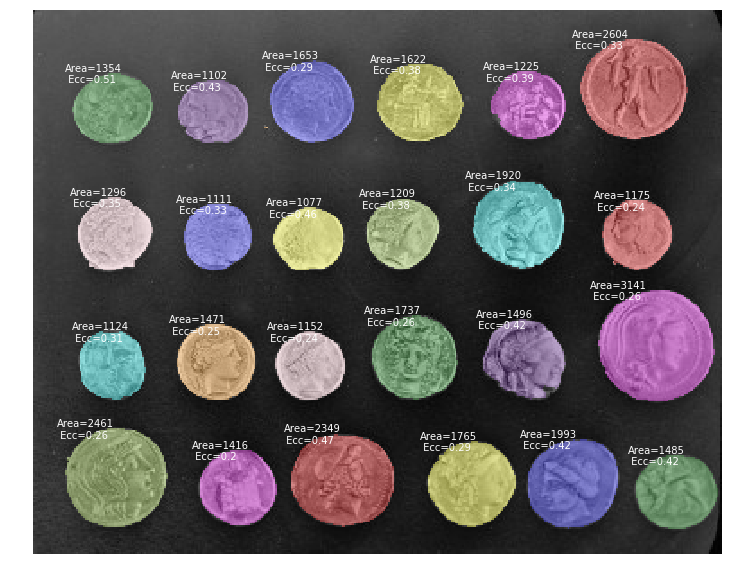

In [3]:
# use the Sobel operator for computing the amplitude of the gradien
# the amplitude of the gradient provides a good elevation map
elevation_map = sobel(coins)

# choose markers from extreme parts of histogram of grey value (from above)
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 160] = 2

# Watershed lines separate these catchment basins, and correspond to the desired segmentation
# Compute the watershed transform
segmentation = watershed(elevation_map, markers)

# remove small holes with mathematical morphology
segmentation = ndi.binary_fill_holes(segmentation - 1)

# label all the coins one by one using ndi.label:
labeled_coins, _ = ndi.label(segmentation)

# overlay coins with color labels
coin_label_overlay = label2rgb(labeled_coins-1, image=coins)

# calculate the area and eccentricity of each coin
# display the transformed original image with the above info
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.imshow(coin_label_overlay)
ax.axis('off');
for region in regionprops(labeled_coins):
    # skip small areas
    if region.area > 100:
        minr, minc, maxr, maxc = region.bbox
        annot = "Area={0}\n Ecc={1:.2g}".format(region.area, region.eccentricity)
        ax.text(minc-5, minr+5, annot, color="white")

## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

**The given tutorial does not yield a decent output as shown below. The following codes are adapted and derived from the given tutorial.**

*Output from the tutorial*

![](images/panorama-stitching-output-failed.png)

#### Import images and convert to grayscale
The images used are of the Berkeley International House! You may notice the difference in angles of three images are NOT that significant. I tried to use the ones with wider perspectives, but they ended up with a still image of ihouse02.jpg in the middle and uncountable lines in color on each sides (even more failing than the above). These three are the only few combinations I tried that worked well. 

In [4]:
from skimage.io import ImageCollection
from skimage.color import rgb2gray
from skimage.transform import rescale

# Load a series of images into an ``ImageCollection`` with a wildcard, as they share similar names. 
imgs = ImageCollection('./images/ihouse*')
color_imgs = [rescale(img, 0.25) for img in imgs[:3]]
imgs = [rgb2gray(img) for img in color_imgs]

/Users/leoli/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/leoli/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/leoli/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


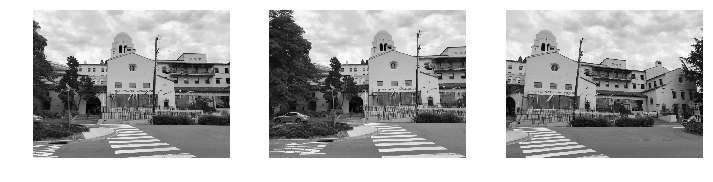

In [5]:
# Pre-processing into greyscale & Previewing
plt.figure(figsize=(12, 10))
for i, img in enumerate(imgs):
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(img, cmap='gray')
    plt.gca().axis('off')

#### Feature Detection and Matching

I'm experiencing TypeErrors for feature matching graphs. It seems that the argument passed in for ploting contains only one element and it requires a tuple of two, though GitHub page of matplotlib & their official document both say the first element of the tuple (c, array) where c = colors is not necessary anymore, but it still does not work on my laptop so I've commented them out. 

Error Message: 

"Invalid RGBA argument: array([[ 0.6307721 ], [ 0.67431267], [ 0.14538365]])"


In [6]:
from skimage.feature import ORB, match_descriptors

# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=800, fast_threshold=0.05)
keypoints, descriptors = [], []
for img in imgs:
    orb.detect_and_extract(img)
    keypoints.append(orb.keypoints)
    descriptors.append(orb.descriptors)

In [7]:
# Match descriptors between left/right images and the center
matches = []
target_index = 1
for i, img in enumerate(imgs):
    if i==target_index:
        matches.append(None)
    else:
        matches.append(match_descriptors(descriptors[i], descriptors[target_index], cross_check=True))

Inspect these matched features side-by-side using the convenience function ``skimage.feature.plot_matches``

*ORB failed to show to are commented out.*

In [8]:
#from skimage.feature import plot_matches

#for i, img in enumerate(imgs):
#    plt.figure(figsize=(12, 8))
#    if i != target_index:
#        plt.imshow(rgb2gray(img), cmap='gray')
#        plot_matches(plt.gca(), img, imgs[target_index], keypoints[i], keypoints[target_index], matches[i])
#        plt.gca().axis('off')
#        plt.show();

In [9]:
# applying RANdom SAmple Consensus (RANSAC) to filter out false matches
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

robust_models, inliers = [], []
for i, img in enumerate(imgs):
    if i != target_index:
        # Select keypoints from 
        #   * source (image to be registered)
        #   * target (reference image): pano1, our middle frame registration target
        src = keypoints[i][matches[i][:, 0]][:, ::-1]
        dst = keypoints[target_index][matches[i][:, 1]][:, ::-1]
        model_robust, inlier = ransac((src, dst), ProjectiveTransform,
                                       min_samples=4, residual_threshold=1, max_trials=300)
        robust_models.append(model_robust)
        inliers.append(inlier)
    else:
        robust_models.append(None)
        inliers.append(None)

Inspect these matched features side-by-side using the convenience function ``skimage.feature.plot_matches``

*ORB failed to show to are commented out.*

In [10]:
# Check the best match subsets from ihouse01 -> ihouse02, and ihouse02 -> ihouse03

#for i, img in enumerate(imgs):
#    plt.figure(figsize=(12, 8))
#    if i != target_index:
#        plt.imshow(rgb2gray(img), cmap='gray')
#        plot_matches(plt.gca(), img, imgs[target_index], keypoints[i], keypoints[target_index], matches[i][inliers[i]])
#        plt.gca().axis('off')
#        plt.show();

To find the shape of the output image to contain all three transformed images, we consider the extents of all warped images. The following code determines the size of final image and warp the outer images to the center image, using the center image as an anchor.

In [11]:
from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = imgs[target_index].shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Find the extents of both the reference image and the warped target image
all_corners = []
for i, img in enumerate(imgs):
    if i != target_index:
        all_corners.append(robust_models[i](corners))
    else:
        all_corners.append(corners)
all_corners = np.vstack(all_corners)

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)   

In [12]:
# Apply estimated tranformations
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset_target = SimilarityTransform(translation=-corner_min)
# Translate the targets into place
warp_target = warp(imgs[target_index], offset_target.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Get the image mask for later use
target_mask = (warp_target != -1)  # Mask == 1 inside image
warp_target[~target_mask] = 0 

In [13]:
# Now warp to the targets
warped_imgs, masks = [], []
for i, img in enumerate(imgs):
    if i != target_index:
        transform = (robust_models[i] + offset_target).inverse
        warped = warp(img, transform, order=3,
                    output_shape=output_shape, cval=-1)
        mask = (warped != -1)  # Mask == 1 inside image
        warped[~mask] = 0 
        warped_imgs.append(warped)
        masks.append(mask)
    else:
        masks.append(target_mask)
        warped_imgs.append(warp_target)

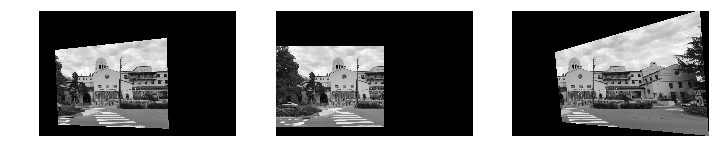

In [14]:
# Inspect the warped images
plt.figure(figsize=(12, 8))
for i, img in enumerate(warped_imgs):
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(img, cmap='gray')
    plt.gca().axis('off')

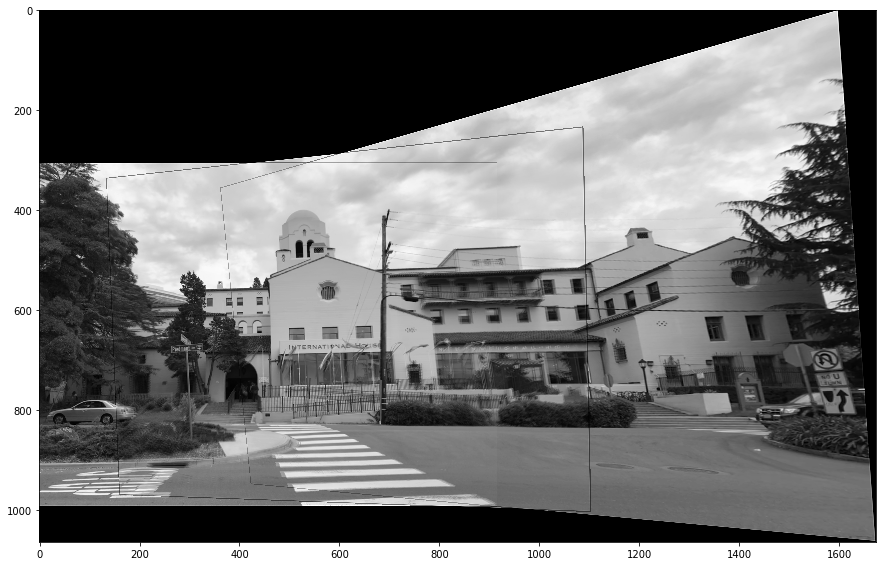

In [15]:
# Now we combine the images
merged = sum(warped_imgs)
overlap = sum(masks)
# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.figure(figsize=(15, 12))
plt.imshow(normalized, cmap='gray')

Now we step back and focus on stitching images along a minimum-cost path.

In [16]:
#define seed points
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 4],
              [xmax, ymax // 4]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 4],
              [xmax, 2*ymax // 4]]

# Start anywhere along the top and bottom, right of center, extended
mask_pts13 = [[0,    2.75*ymax // 4],
              [xmax, 2.75*ymax // 4]]

In [17]:
from skimage.measure import label

# Construct a cost array by defining a cost function
# To combine the images by dividing along the minimum cost path
def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

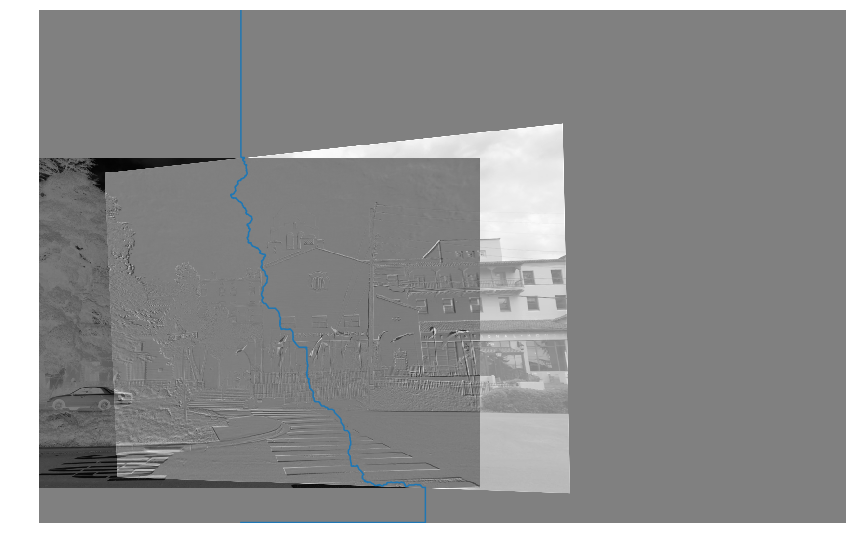

In [18]:
from skimage.graph import route_through_array

# Start with the absolute value of the difference image.
# np.abs is necessary because we don't want negative costs!
costs01 = generate_costs(np.abs(warped_imgs[0] - warped_imgs[1]),
                         masks[0] & masks[1])
costs01[0,  :] = 0
costs01[-1, :] = 0

pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)
# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

# Visualize the minimum-cost path
ig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(warped_imgs[0] - warped_imgs[1], cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');

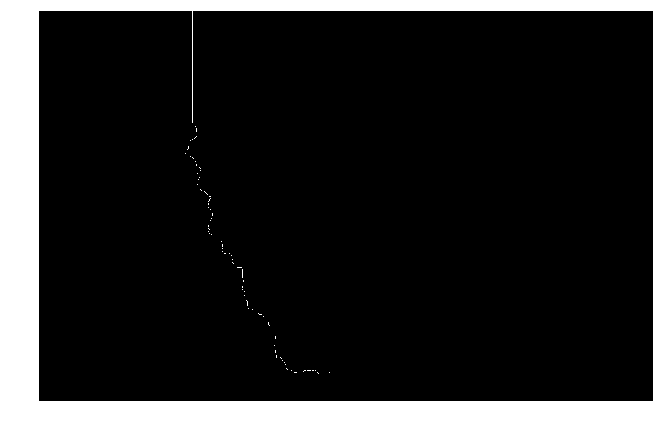

In [19]:
# Convert the minimum-cost path into a mask
# Start with an array of zeros and place the path
masks[0] = np.zeros_like(warped_imgs[0], dtype=np.uint8)
masks[0][pts[:, 0], pts[:, 1]] = 1
fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(masks[0], cmap='gray')
ax.axis('off');

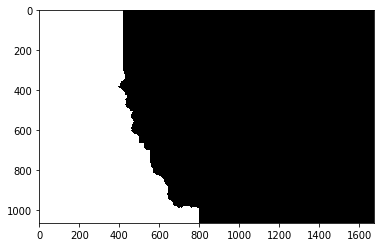

In [20]:
# Label the various contiguous regions in the image using skimage.measure.label
from skimage.measure import label

# Labeling starts with one at point (0, 0)
masks[0] = (label(masks[0], connectivity=1, background=-1) == 1)

# The result
plt.imshow(masks[0], cmap='gray');

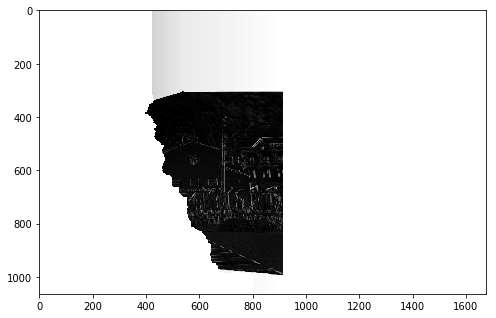

In [21]:
# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs12 = generate_costs(np.abs(warped_imgs[1] - warped_imgs[2]),
                         masks[1] & masks[2])

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0
costs12[masks[0] > 0] = 1

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(costs12, cmap='gray');

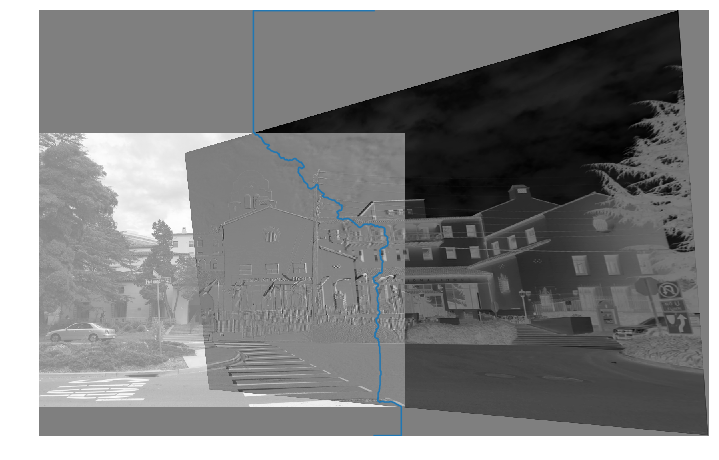

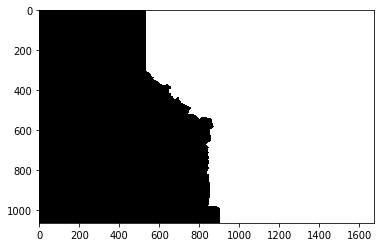

In [22]:
# Compute the minimal cost path
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)
# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

fig, ax = plt.subplots(figsize=(12, 12))
# Plot the difference image
ax.imshow(warped_imgs[1] - warped_imgs[2], cmap='gray')
# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);
ax.axis('off');
plt.show();

# Convert the minimum-cost path into a mask
# Start with an array of zeros and place the path
masks[2] = np.zeros_like(warped_imgs[0], dtype=np.uint8)
masks[2][pts[:, 0], pts[:, 1]] = 1
masks[2] = (label(masks[2], connectivity=1, background=-1) == 3)
plt.imshow(masks[2], cmap='gray');

In [23]:
# The last mask for the middle image is one of exclusion
# it will be displayed everywhere mask0 and mask2 are not
masks[1] = ~(masks[0] | masks[2]).astype(bool)

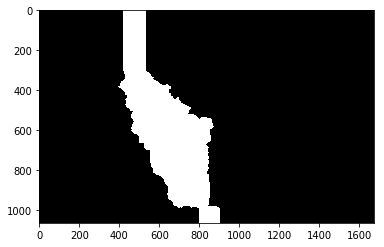

In [24]:
plt.imshow(masks[1], cmap='gray')

In [25]:
# Define a convenience function to place masks in alpha channels
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

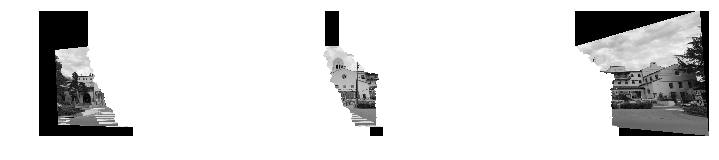

In [26]:
# Obtain final, alpha blended individual images and inspect them
plt.figure(figsize=(12, 12))
for i, img in enumerate(warped_imgs):
    final = add_alpha(img, masks[i])
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(final, cmap='gray')
    plt.gca().axis('off')

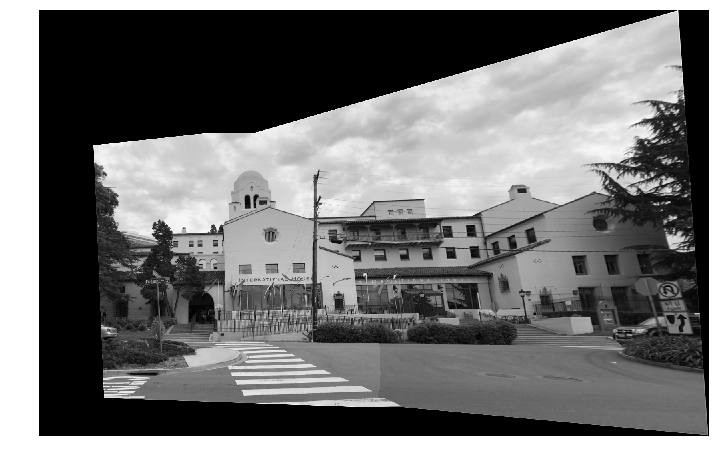

In [27]:
plt.figure(figsize=(12, 12))
for i, img in enumerate(warped_imgs):
    final = add_alpha(img, masks[i])
    # This is a perfect combination, but matplotlib's interpolation
    # makes it appear to have gaps. So we turn it off.
    plt.imshow(final, cmap='gray', interpolation=None)
    plt.gca().axis('off')

Now we redo this process with colors to have a colored image.

In [28]:
# Identical transforms as before, except this time operating on original color images
offset_target = SimilarityTransform(translation=-corner_min)
warp_target = warp(color_imgs[target_index], offset_target.inverse, order=3,
                    output_shape=output_shape, cval=-1)
color_warped_imgs = []
for i, img in enumerate(color_imgs):
    if i != target_index:
        transform = (robust_models[i] + offset_target).inverse
        warped = warp(img, transform, order=3,
                    output_shape=output_shape, cval=-1)
        color_warped_imgs.append(warped)
    else:
        color_warped_imgs.append(warp_target)

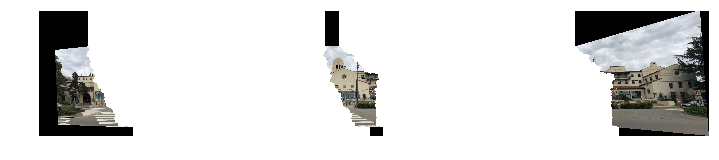

In [29]:
# Obtain final, alpha blended individual images and inspect them
plt.figure(figsize=(12, 12))
for i, img in enumerate(color_warped_imgs):
    final = add_alpha(img, masks[i])
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(final)
    plt.gca().axis('off')

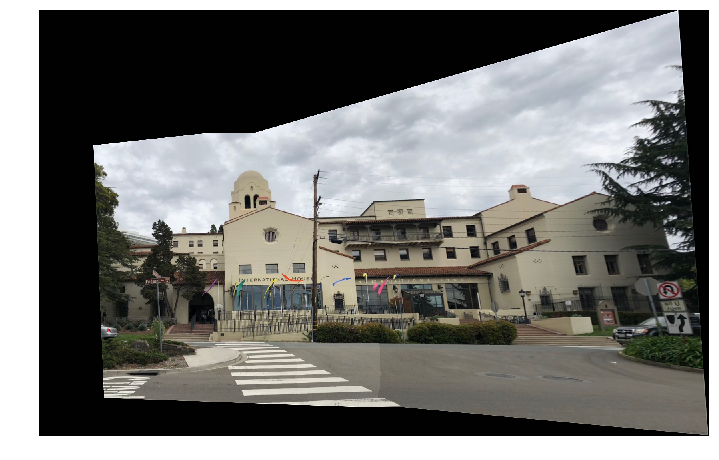

In [41]:
plt.figure(figsize=(12, 12))
for i, img in enumerate(color_warped_imgs):
    final = add_alpha(img, masks[i])
    # This is a perfect combination, but matplotlib's interpolation
    # makes it appear to have gaps. So we turn it off.
    plt.imshow(final, interpolation=None)
    plt.gca().axis('off')

# Save the image from plotting directly
plt.savefig('./images/pano-stitching-output-success.png', dpi=300)

#### Save the Image

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.